=== DATA PREPARATION PIPELINE ===

1. Setting up database...

2. Loading data...
✓ Данные загружены из CSV файла
✓ Data loaded: 5630 records, 20 features

3. Exploratory Data Analysis...

Basic Information:
Dataset shape: (5630, 20)

Data types:
CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmoun

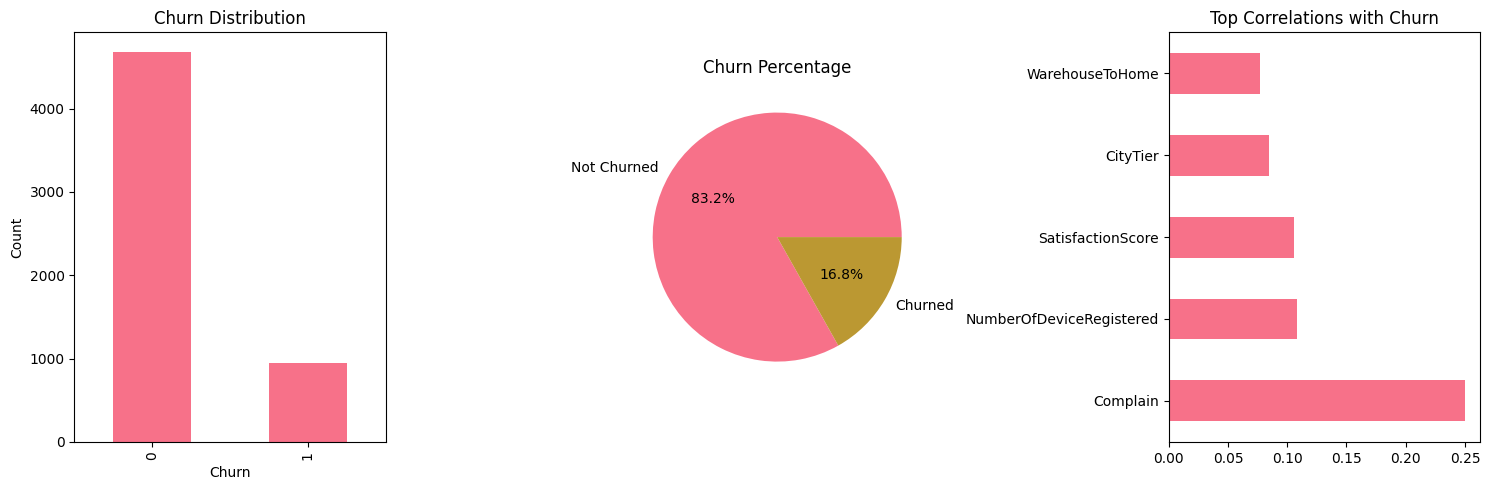


4. Data Cleaning...
Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')
✓ Removed 0 duplicates
✓ Missing values, duplicates, and outliers handled

5. Feature Engineering...
Final Churn=1 count: 948
✓ Feature engineering completed. Final shape: (5630, 37)
Final Churn=1 count: 948


C:\Users\Артем\AppData\Local\Temp\ipykernel_16008\277775198.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\Артем\AppData\Local\Temp\ipykernel_16008\277775198.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

✓ Cleaned data saved to PostgreSQL

6. Feature Scaling...
✓ Feature scaling completed. Final features: 39
✓ Features layer saved to PostgreSQL

✅ DATA PREPARATION COMPLETED!
Raw data: (5630, 20)
Cleaned data: (5630, 37)
Final features: (5630, 39)


In [ ]:
# Data Preparation Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sys

# Add project root to path
sys.path.append('..')
from src.config.database import get_connection_string
from data.load_data import load_data_from_csv
from src.utils.database_utils import execute_sql_file

# Configuration
plt.style.use('default')
sns.set_palette("husl")

print("=== DATA PREPARATION PIPELINE ===")

# 0. Database Setup
print("\n1. Setting up database...")
engine = create_engine(get_connection_string())

# 1. Delete layer
execute_sql_file(engine, '../sql/drop_layers.sql')

# 2. Data Loading
print("\n2. Loading data...")
df = load_data_from_csv()
print(f"✓ Data loaded: {df.shape[0]} records, {df.shape[1]} features")

# 3. EDA
print("\n3. Exploratory Data Analysis...")

# Basic info
print("\nBasic Information:")
print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Target variable analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
churn_pct = df['Churn'].value_counts(normalize=True) * 100
plt.pie(churn_pct.values, labels=['Not Churned', 'Churned'], autopct='%1.1f%%')
plt.title('Churn Percentage')

plt.subplot(1, 3, 3)
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_with_churn = df[numerical_cols].corr()['Churn'].sort_values(ascending=False)
correlation_with_churn[1:6].plot(kind='barh')  # Exclude Churn itself
plt.title('Top Correlations with Churn')

plt.tight_layout()
plt.show()

# 4. Data Cleaning
print("\n4. Data Cleaning...")
df_clean = df.copy()

print(df_clean.columns)

# Handle missing values
for col in df_clean.columns:
    if col not in ["Churn", "CustomerID"]:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['float64', 'int64']:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Remove duplicates
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates()
final_count = len(df_clean)
print(f"✓ Removed {initial_count - final_count} duplicates")

# Handle outliers
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if col not in ["Churn", "CustomerID"]:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])
    

print("✓ Missing values, duplicates, and outliers handled")

# 5. Feature Engineering
print("\n5. Feature Engineering...")

# Create new features
df_clean['AvgOrdersPerMonth'] = df_clean['OrderCount'] / (df_clean['Tenure'] + 1)
df_clean['AvgCashbackPerOrder'] = df_clean['CashbackAmount'] / (df_clean['OrderCount'] + 1)

# Encode categorical variables
categorical_cols = df_clean.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    if df_clean[col].nunique() == 2:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])
        label_encoders[col] = le
    else:
        dummies = pd.get_dummies(df_clean[col], prefix=col)
        df_clean = pd.concat([df_clean, dummies], axis=1)
        df_clean.drop(col, axis=1, inplace=True)

print(f"✓ Feature engineering completed. Final shape: {df_clean.shape}")

# Save to cleaned layer
df_clean.to_sql('cleaned_layer', engine, if_exists='replace', index=False)
print("✓ Cleaned data saved to PostgreSQL")

# 6. Feature Scaling
print("\n6. Feature Scaling...")
df_features = df_clean.copy()

# Separate target and features
if 'CustomerID' in df_features.columns:
    customer_ids = df_features['CustomerID']
    features_to_scale = df_features.drop(['CustomerID', 'Churn'], axis=1)
else:
    features_to_scale = df_features.drop('Churn', axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# Create final features dataframe
df_final = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
df_final['Churn'] = df_features['Churn'].values
if 'CustomerID' in df_features.columns:
    df_final['CustomerID'] = customer_ids.values

# Add engineered features
df_final['EngagementScore'] = df_final['HourSpendOnApp'] * df_final['OrderCount']
df_final['SatisfactionComplainRatio'] = df_final['SatisfactionScore'] / (df_final['Complain'] + 1)

print(f"✓ Feature scaling completed. Final features: {df_final.shape[1]}")

# Save to features layer
df_final.to_sql('features_layer', engine, if_exists='replace', index=False)
print("✓ Features layer saved to PostgreSQL")

print("\n✅ DATA PREPARATION COMPLETED!")
print(f"Raw data: {df.shape}")
print(f"Cleaned data: {df_clean.shape}") 
print(f"Final features: {df_final.shape}")

# Create layer
execute_sql_file(engine, '../sql/layers.sql')